📈 Dynamic Stock Correlation & Risk Analysis

In [19]:
# Install packages
!pip install yfinance pandas matplotlib seaborn streamlit riskfolio-lib plotly

# Install libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import plotly.express as px

try:
    import riskfolio as rp
    riskfolio_available = True
except Exception as e:
    print("❌ riskfolio-lib failed to import:", e)
    riskfolio_available = False

Configuration of Tickers & Dates

In [20]:
tickers = ["ANET", "FN", "ALAB", "NVDA"]
start = "2010-01-01"
end = "2024-12-31"
threshold_days = 3  # allow small gaps like weekends/market holidays/data source lag

freq = "Monthly"  # "Daily", "Monthly", or "Yearly"
abs_or_pct = "% Change (Relative)"  # or "Price Difference (Absolute)"
overlap = "No"  # "Yes" if overlapping for YoY
corr_type = "Pearson"  # or "Kendall", "Spearman"
window = 60  # rolling correlation window

Data Download from Yahoo Finance

In [21]:
data = {}
incomplete_data_notes = []

for ticker in tickers:
    print(f"📥 Downloading {ticker}...")
    stock = yf.download(ticker, start=start, end=end, group_by="column", auto_adjust=True)

    if not stock.empty:
        actual_start = stock.index.min().date()
        actual_end = stock.index.max().date()
        user_start = pd.to_datetime(start).date()
        user_end = pd.to_datetime(end).date()

        if (actual_start - user_start).days > threshold_days or (user_end - actual_end).days > threshold_days:
            reason = "IPO, delisting, or missing Yahoo data"
            incomplete_data_notes.append({
                "Ticker": ticker,
                "Available From": actual_start,
                "Available To": actual_end,
                "Requested From": user_start,
                "Requested To": user_end,
                "Reason (likely)": reason
            })

        # Extract valid series
        if "Adj Close" in stock.columns:
            val = stock["Adj Close"]
        elif "Close" in stock.columns:
            val = stock["Close"]
        else:
            continue

        if isinstance(val, pd.Series):
            data[ticker] = val
        elif isinstance(val, pd.DataFrame) and val.shape[1] == 1:
            data[ticker] = val.iloc[:, 0]
    else:
        print(f"{ticker} returned no data.")

# Show missing data summary if applicable


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📥 Downloading ANET...
📥 Downloading FN...
📥 Downloading ALAB...
📥 Downloading NVDA...


Dataframe formation

In [22]:
if len(data) == 0:
    print("❌ No valid data downloaded.")
    
if incomplete_data_notes:
    print("⚠️ Some stocks have limited data:")
    display(pd.DataFrame(incomplete_data_notes))
    
df = pd.DataFrame(data).dropna()
df.tail()

⚠️ Some stocks have limited data:


,Ticker,Available From,Available To,Requested From,Requested To,Reason (likely)
0,ANET,2014-06-06,2024-12-30,2010-01-01,2024-12-31,"IPO, delisting, or missing Yahoo data"
1,FN,2010-06-25,2024-12-30,2010-01-01,2024-12-31,"IPO, delisting, or missing Yahoo data"
2,ALAB,2024-03-20,2024-12-30,2010-01-01,2024-12-31,"IPO, delisting, or missing Yahoo data"


,ANET,FN,ALAB,NVDA
Date,,,,
2024-12-23,113.089996,220.889999,135.570007,139.657150
2024-12-24,114.650002,221.240005,141.600006,140.207108
2024-12-26,114.860001,224.149994,145.809998,139.917130
2024-12-27,113.029999,219.470001,141.529999,136.997391
2024-12-30,111.449997,214.759995,136.419998,137.477356


Price History Visualisations

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



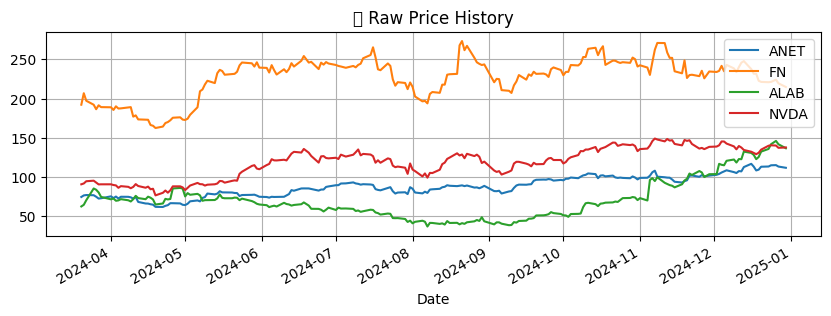

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



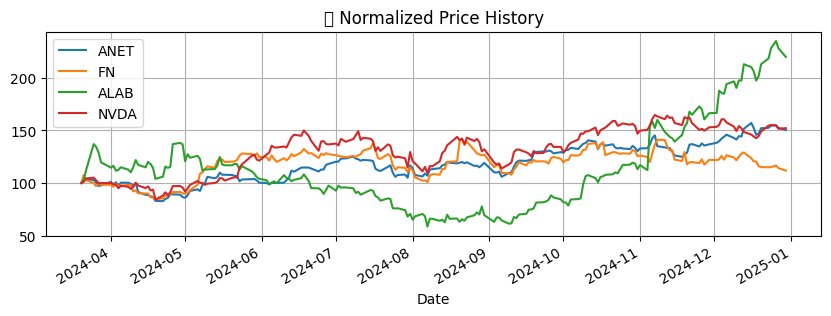

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



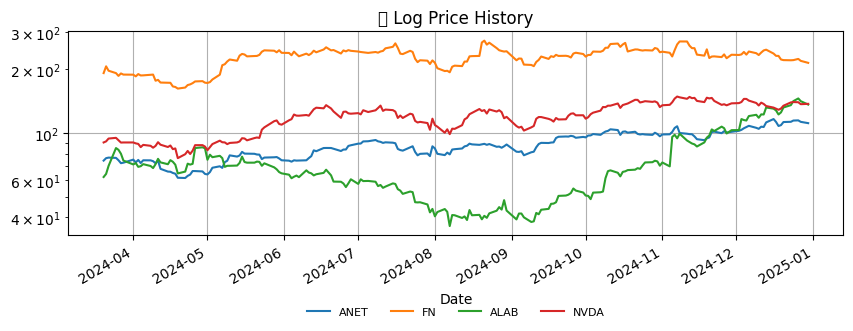

In [23]:
# Raw
df.plot(title="📊 Raw Price History", figsize=(10, 3))
plt.grid(True)
plt.show()

# Normalized
(df / df.iloc[0] * 100).plot(title="📊 Normalized Price History", figsize=(10, 3))
plt.grid(True)
plt.show()

# Log scale
fig, ax = plt.subplots(figsize=(10, 3))
df.plot(ax=ax, logy=True)
ax.set_title("📊 Log Price History")
ax.grid(True)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=min(4, len(df.columns)), frameon=False, fontsize=8)
plt.show()

Return Calculation (based on frequency and method)

In [24]:
if freq == "Daily":
    temp = df
elif freq == "Monthly":
    temp = df.resample("M").last()
elif freq == "Yearly":
    temp = df.resample("Y").last()

if abs_or_pct == "% Change (Relative)":
    if freq == "Yearly" and overlap == "Yes":
        returns = df.pct_change(252).dropna()
    else:
        returns = temp.pct_change().dropna()
else:
    returns = temp.diff().dropna()

# 📏 Warn if not enough data points
if len(returns) < 30:
    print("⚠️ Fewer than 30 data points — correlation may be unreliable.")

returns.tail()


⚠️ Fewer than 30 data points — correlation may be unreliable.


C:\Users\genin\AppData\Local\Temp\ipykernel_6604\4040831747.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,ANET,FN,ALAB,NVDA
Date,,,,
2024-08-31,0.019709,0.104688,-0.017792,0.020082
2024-09-30,0.086140,-0.029592,0.216674,0.017428
2024-10-31,0.006826,0.019159,0.339187,0.093215
2024-11-30,0.050150,-0.026518,0.471636,0.041353
2024-12-31,0.098517,-0.084491,0.321259,-0.005429


Correlation Matrix

In [25]:
corr = returns.corr(method=corr_type.lower())

# Key correlation highlights
corr_pairs = corr.where(~np.eye(len(corr), dtype=bool))
corr_flat = corr_pairs.unstack().dropna().reset_index()
corr_flat.columns = ['Stock A', 'Stock B', 'Correlation']
corr_flat = corr_flat[corr_flat['Stock A'] < corr_flat['Stock B']]

# Top positive/negative
display(corr_flat.sort_values("Correlation", ascending=False).head(5))
display(corr_flat.sort_values("Correlation", ascending=True).head(5))

# Strong correlations
threshold = 0.8
strong_corr = corr_flat[abs(corr_flat["Correlation"]) > threshold]
display(strong_corr)

# Correlation matrix heatmap
px.imshow(
    corr, text_auto=".2f", color_continuous_scale="RdBu_r", aspect="auto", title=f"{corr_type} Correlation Matrix"
).show()

,Stock A,Stock B,Correlation
5,FN,NVDA,0.890757
2,ANET,NVDA,0.700016
0,ANET,FN,0.508827
6,ALAB,ANET,-0.176646
8,ALAB,NVDA,-0.272069


,Stock A,Stock B,Correlation
7,ALAB,FN,-0.441435
8,ALAB,NVDA,-0.272069
6,ALAB,ANET,-0.176646
0,ANET,FN,0.508827
2,ANET,NVDA,0.700016


,Stock A,Stock B,Correlation
5,FN,NVDA,0.890757


Rolling Correlation

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



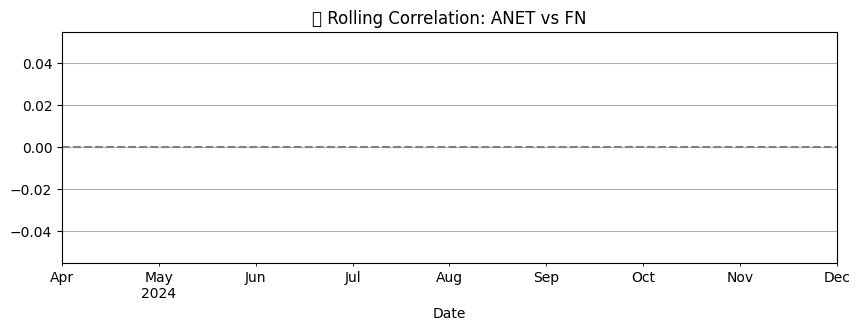

In [26]:
#dyanamic version
if len(tickers) >= 2:
    t1, t2 = tickers[0], tickers[1]
    rolling = returns[t1].rolling(window).corr(returns[t2])
    rolling.plot(title=f"🔁 Rolling Correlation: {t1} vs {t2}", figsize=(10, 3))
    plt.axhline(0, linestyle="--", color="gray")
    plt.grid(True)
    plt.show()


Risk Metrics & Portfolio Optimization

,VaR_0.05,CVaR_0.05,Sharpe
ANET,-0.0736,-0.1152,9.1880
FN,-0.0932,-0.0990,2.4192
ALAB,-0.2607,-0.2755,6.0034
NVDA,-0.0492,-0.0528,8.2120


,ANET,FN,ALAB,NVDA
weights,0.4332,0.0,0.2017,0.3652


C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



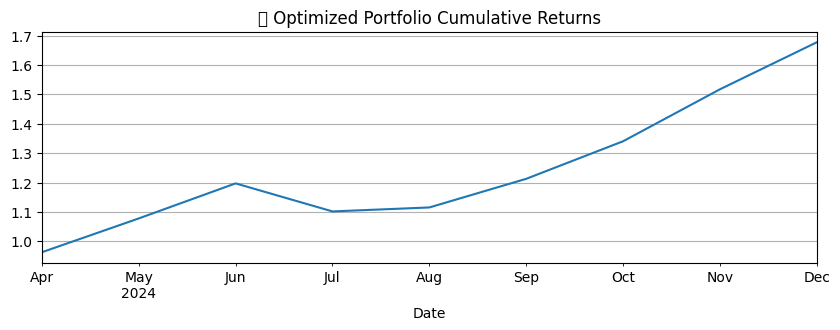

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



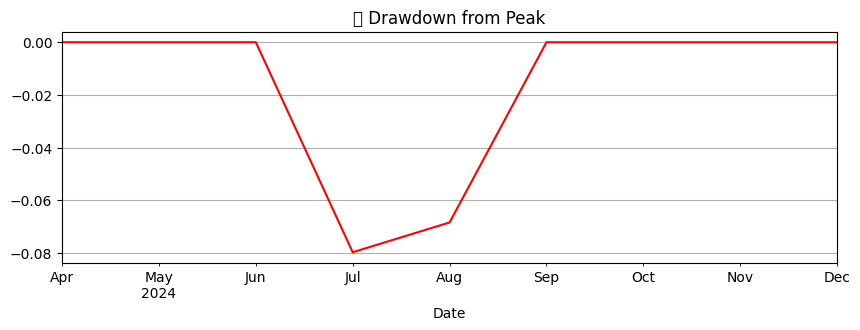

C:\Users\genin\AppData\Local\Temp\ipykernel_6604\3527328989.py:34: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



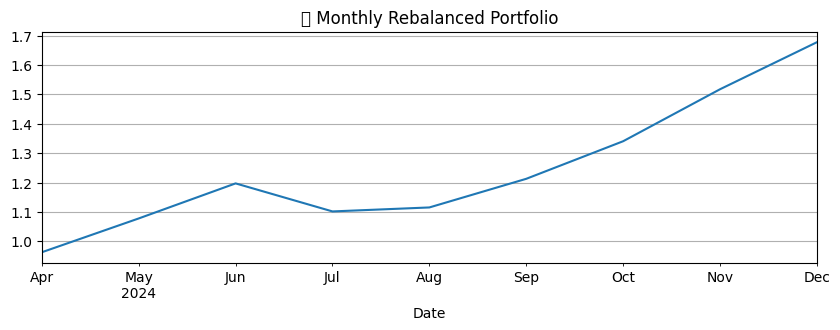

In [27]:
def get_risk_metrics(returns, alpha=0.05, rf=0.0):
    metrics = {}
    for col in returns.columns:
        r = returns[col].dropna()
        var = np.percentile(r, 100 * alpha)
        cvar = r[r <= var].mean()
        sharpe = (r.mean() - rf) / r.std() * np.sqrt(252)  # annualized Sharpe
        metrics[col] = {"VaR_0.05": var, "CVaR_0.05": cvar, "Sharpe": sharpe}
    return pd.DataFrame(metrics).T

if riskfolio_available and len(tickers) > 1:
    port = rp.Portfolio(returns=returns)
    port.assets_stats(method_mu='hist', method_cov='hist')
    risk = get_risk_metrics(returns)
    display(risk.round(4))

    w = port.optimization(model="Classic", rm="MV", obj="Sharpe", hist=True)
    display(w.T.round(4))

    selected_tickers = w[w > 0].index.tolist()
    selected_weights = w.loc[selected_tickers].values.flatten()  # 🔧 flatten to 1D

    weighted_returns = returns[selected_tickers].mul(selected_weights, axis=1).sum(axis=1)
    cumulative_returns = (1 + weighted_returns).cumprod()
    cumulative_returns.plot(title="📈 Optimized Portfolio Cumulative Returns", figsize=(10, 3))
    plt.grid(True)
    plt.show()

    drawdown = (cumulative_returns - cumulative_returns.cummax()) / cumulative_returns.cummax()
    drawdown.plot(title="📉 Drawdown from Peak", figsize=(10, 3), color="red")
    plt.grid(True)
    plt.show()

    rebalance_returns = weighted_returns.resample("M").apply(lambda x: (1 + x).prod() - 1)
    rebalance_cumulative = (1 + rebalance_returns).cumprod()
    rebalance_cumulative.plot(title="🔁 Monthly Rebalanced Portfolio", figsize=(10, 3))
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Install riskfolio-lib to enable risk metrics and optimization.")